In [51]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle

In [58]:
def symplectic_stabilizer(stabList):
    """
    Input: (str) list of stabilizers in the form "XXI;IXX;XXX"
    Output: ([np.array, np.array]) symplectic representation matrix
    """
    stab = stabList.split(";")
    stab = [i.replace(" ","") for i in stab]
    
    #test
    lenStabs = [len(i) for i in stab]
    eqLens = all(i==lenStabs[0] for i in lenStabs)
    if eqLens==False:
        print("Stab list no equal length")
        return 0
    
    matrixX = np.zeros((len(stab),lenStabs[0]))
    matrixZ = np.zeros((len(stab),lenStabs[0]))

    for indxgen, gen in enumerate(stab):
        for indxop,op in enumerate(gen):
            if op=='X':
                matrixX[indxgen, indxop] = 1
            elif op=='Z':
                matrixZ[indxgen, indxop] = 1
            elif op=='Y':
                matrixX[indxgen, indxop] = 1
                matrixZ[indxgen, indxop] = 1
    
    return [matrixX, matrixZ]

In [59]:
def symplectic_innerProd(op1, op2):
    """
    Input: opi = [binary vector, binary vector]
    Output: (0 or 1) symplectic innerProduct between op1 and op2
    """
    op1 = np.asarray(op1)
    op2 = np.asarray(op2)
    return np.sum(op1[0]*op2[1] + op1[1]*op2[0])%2

In [60]:
def error_syndrome(stabList, error):
    """
    Input:  symplectic matrix of stabilizer
    Output: np.array with error syndrome:
    """
    error_synd = np.zeros(stabList[0].shape[0])
    for i in range(stabList[0].shape[0]):
        error_synd[i] = symplectic_innerProd([stabList[0][i], stabList[1][i]], error)
    
    return error_synd.astype(int)

In [61]:
def dump_chunk_errors(errorList, iterat):
    with open("{iterat}_error.p".format(iterat=str(iterat)), 'wb') as fp:
        pickle.dump(errorList, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_chunk_errors(iterat):
    with open("{iterat}_error.p".format(iterat=str(iterat)), 'rb') as fp:
        chunkErrors = pickle.load(fp)
    return chunkErrors

In [62]:
def classify_errors_small(stabList):
    """
    Input: stabilizerList
    Output: (dict) with key syndrome and value list of all posible errors in symplectic form
    """
    class_errors = {}
    symplectic_matrix = symplectic_stabilizer(stabList)
    
    numQubits = symplectic_matrix[0].shape[1]
    numStabilizers = symplectic_matrix[0].shape[0]
    
    for error in itertools.product([0,1], repeat=numStabilizers):
        class_errors[tuple(error)] = []
    
    oneError = [np.array(i) for i in itertools.product([0, 1], repeat=numQubits)]
    errors = [[x,y] for x,y in itertools.product(oneError, oneError)]
    
    for error in errors:
        syndrome = error_syndrome(symplectic_matrix, error)
        class_errors[tuple(syndrome)].append(error)

    return class_errors

In [63]:
def classify_errors_chunks(stabList,  chunkSize = 50000):
    """
    Input: stabilizerList
    Output: (dict) with key syndrome and value list of all posible errors in symplectic form
    """
    class_errors = {}
    symplectic_matrix = symplectic_stabilizer(stabList)

    numQubits = symplectic_matrix[0].shape[1]
    numStabilizers = symplectic_matrix[0].shape[0]
    
    perm1 = itertools.product([0,1], repeat=numStabilizers)

    for error in perm1:
        class_errors[tuple(error)] = []
    
    perm2 = itertools.product([0, 1], repeat=numQubits)
    oneError = []
    for i in perm2:
        oneError.append(np.array(i))
    
    errors = []
    perm3 = itertools.product(oneError, oneError)
    iteration = 0
    for x,y in perm3:
        errors.append([x,y])
        if len(errors)>=chunkSize:
            iteration+=1
            dump_chunk_errors(errors, iteration)
            errors = []
                        
    while iteration>=0:
        
        for error in errors:
            syndrome = error_syndrome(symplectic_matrix, error)

            class_errors[tuple(syndrome)].append(error)

        if iteration!=0:
            errors = load_chunk_errors(iteration)
        iteration-=1

    return class_errors
    

In [65]:
def classify_errors_weight(stabList, weights):
    """
    Input: stabilizerList
    Output: (dict) with key syndrome and value list of all posible errors in symplectic form
    """
    class_errors = {}
    symplectic_matrix = symplectic_stabilizer(stabList)
    
    numQubits = symplectic_matrix[0].shape[1]
    numStabilizers = symplectic_matrix[0].shape[0]
    
    for error in itertools.product([0,1], repeat=numStabilizers):
        class_errors[tuple(error)] = []
    
    for weight in weights:
        oneError = [np.array(i) for i in itertools.product([0, 1], repeat=numQubits)]
        errors = [[x,y] for x,y in itertools.product(oneError, oneError) if np.sum(np.maximum(x,y))==weight]

        for error in errors:
            syndrome = error_syndrome(symplectic_matrix, error)
            class_errors[tuple(syndrome)].append(error)

    return class_errors
    

In [64]:
def classify_errors(stabList, chunkSize = 0, weights = []):
    """
    Input: Symplectic stabilizer list
    Output:(dict) Classification of errors requested
    """
    
    if chunkSize == 0 and (not weights):
        return classify_errors_small(stabList)
    
    elif chunkSize>0 and (not weights):
        return classify_errors_chunks(stabList,  chunkSize = chunkSize)
    
    elif chunkSize==0 and (not not weights):
        return classify_errors_weight(stabList, weights)
    else:
        print("Classification not possible")

In [66]:
def minimum_weight_error(errors):
    """
    Input: dictionary with errors in syndromes
    Output: dictionary with lowest weight error in syndromes
    """
    minWeight = {}
    for syndr in errors:
        if not errors[syndr]:
            continue
        minW = errors[syndr][0][0].shape[0]
        detected = []
        for error in errors[syndr]:
            x,y = error
            #weight of error
            w = np.sum(np.maximum(x,y))
            if w<minW:
                minW = w
                detected = [error]
            elif w==minW:
                detected.append(error)
        minWeight[syndr] = detected
    return minWeight      

In [67]:
def symplectic2txt(vector):
    """
    Input: a symplectic vector
    Output: txt operators
    """
    x,z = vector
    operator = ""
    for i in range(x.shape[0]):
        if x[i]==1 and z[i]==0:
            operator+="X"
        elif x[i]==0 and z[i]==1:
            operator+="Z"
        elif x[i]==1 and z[i]==1:
            operator+="Y"
        elif x[i]==0 and z[i]==0:
            operator+="I"
            
    return operator

In [68]:
def syndromes_symplectic2txt(syndrom_dict):
    """
    Input: dictionary of syndromes in symplectic
    Output: dictionary of syndromes in txt
    """
    syndromes = syndrom_dict.copy()
    for i in syndromes:
        if len(syndromes[i])==1:
            syndromes[i] = symplectic2txt(*syndromes[i])
        else:
            newtxt = []
            for j in syndromes[i]:
                newtxt.append(symplectic2txt(j))
            syndromes[i] = newtxt
    return syndromes

In [69]:
def distance_of_code(syndromes):
    """
    Input: dict of syndromes in symplectic form
    Output: distance of code
    """
    commutingOps = syndromes[list(syndromes.keys())[0]]
    try:
        dist = commutingOps[0][0].shape[0]
    except IndexError:
        print("Cannot calculate the distance of the code because the normalizer of the stabilizer is empty")
        return -999
    for op in commutingOps:
        x,z = op
        weight = np.sum(np.maximum(x,z))
        
        if weight!=0 and weight<dist:
            dist = weight
    return dist

In [124]:
def fidelity(minWeightErrors, probX = 1/3, probY = 1/3, probZ = 1/3):
    """
    Input: dictionary of minWeightErrors (only works with one encoded qubit)
    Output: calculates fidelity of state after error correction on channel (1- probX - probY - probZ) I + probX (X rho X) + probY (Y rho Y)     probZ (Z rho Z)
    """
    probI = 1 - (probX + probY + probZ) 
    fid = 0
    for error in minWeightErrors:
        if len(minWeightErrors[error])==1:
            probFix = 1
            x,z = minWeightErrors[error][0]        
            for qubit in range(x.shape[0]):
                if x[qubit]==0 and z[qubit]==0:
                    probFix = probFix*probI
                elif x[qubit]==1 and z[qubit]==0:
                    probFix = probFix*probX
                elif x[qubit]==0 and z[qubit]==1:
                    probFix = probFix*probZ
                elif x[qubit]==1 and z[qubit]==1:
                    probFix = probFix*probY
            fid += probFix
    return fid

In [155]:
def probability_threshold(minWeightErrors, epsilon = 0.001):
    numSteps =int( 1//(2*epsilon) + 1 )
    fidel = [fidelity(minWeightErrors, p/3, p/3, p/3) for p in np.linspace(0,1,numSteps)]
    whenOver = np.where(fidel>1-np.linspace(0,1,numSteps), np.linspace(0,1,numSteps), np.zeros(numSteps))
    
    maxprob = 0
    for prob in whenOver:
        if prob > maxprob:
            maxprob = prob
    return maxprob + epsilon

In [122]:
def save_syndromes(nombreArchivo, errorSyndrome) -> None:
    """
    Input: (str, errorSyndrome) saves syndrome in three files, min weights, allErrors and properties
    """
    minErrors = minimum_weight_error(errorSyndrome)
    minErrorsTxt = syndromes_symplectic2txt(minErrors)
    distance = distance_of_code(errorSyndrome)
    
    f = open("{fnombre}_Properties.txt".format(fnombre=nombreArchivo), "w")
    f.write("Distance of code: "+ str(distance))
    f.write("\nCorrectable Errors: ")
    for i in minErrorsTxt:
        f.write("\nSyndrome: "+str(i)+ "; Error: " + str(minErrorsTxt[i]))
    f.close()
    
    with open("{fnombre}_AllErrors.p".format(fnombre=str(nombreArchivo)), 'wb') as fp:
        pickle.dump(errorSyndrome, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open("{fnombre}_MinWeightErrors.p".format(fnombre=str(nombreArchivo)), 'wb') as fp:
        pickle.dump(minErrors, fp, protocol=pickle.HIGHEST_PROTOCOL)
    

In [123]:
def open_syndromes(nombreArchivo):
    """
    Input: (str) name of code 
    Output: error syndrome and minimum weight errors
    """
    with open("{fnombre}_AllErrors.p".format(fnombre=str(nombreArchivo)), 'rb') as fp:
        all_errors = pickle.load(fp)
        
    with open("{fnombre}_MinWeightErrors.p".format(fnombre=str(nombreArchivo)), 'rb') as fp2:
        minWeight_errors = pickle.load(fp2)
    return all_errors, minWeight_errors

In [125]:
errorsfiv= classify_errors("XZZXI; IXZZX; XIXZZ; ZXIXZ", weights=[0,1,2])
errors = classify_errors("XXI; IXX")

In [126]:
dics = minimum_weight_error(errors)
corrErrs = syndromes_symplectic2txt(dics)
distance = distance_of_code(errors)

In [127]:
dicsfiv = minimum_weight_error(errorsfiv)
corrErrsfiv = syndromes_symplectic2txt(dicsfiv)
distancefiv = distance_of_code(errorsfiv)

In [108]:
distancefiv

5

In [156]:
probability_threshold(dicsfiv)

0.13026052104208416

Text(0.5, 1.0, 'Depolarizing channel')

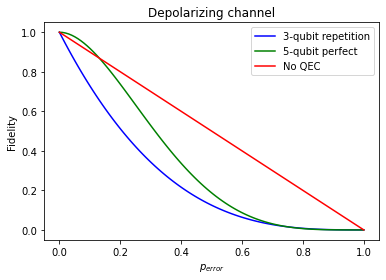

In [116]:
fids = [fidelity(dics, p/3, p/3, p/3) for p in np.linspace(0,1,100)]
fidsf = [fidelity(dicsfiv, p/3, p/3, p/3) for p in np.linspace(0,1,100)]

plt.plot(np.linspace(0,1,100), fids, label = "3-qubit repetition", c = 'b')
plt.plot(np.linspace(0,1,100), fidsf, label = "5-qubit perfect", c = 'g')
plt.plot(np.linspace(0,1,100),1-np.linspace(0,1,100), label = "No QEC", c='r')
plt.legend()
plt.xlabel(r'$p_{error}$')
plt.ylabel("Fidelity")
plt.title("Depolarizing channel")

In [130]:
fids7 = [fidelity(dicsfiv, p/3, p/3, p/3) for p in np.linspace(0,1,1000)]

In [ ]:
f = open("distance.txt", "w")
f.write("Distance of code: "+ str(distance))
f.write("\nCorrectable Errors: ")
for i in corrErrs:
    f.write("\nSyndrome: "+str(i)+ "; Error: " + str(corrErrs[i]))
f.close()

#open and read the file after the appending:
f = open("distance.txt", "r")
print(f.read())

In [ ]:
g1 = "X Y X 1 X Y X 1 Y Z Y 1 1 1 1 1 Y Z Y 1;"
g2 = "Y Z Y 1 Y Z Y 1 Z X Z 1 1 1 1 1 Z X Z 1;"
g3 = "Y Z Y 1 X Y X 1 X Y X 1 Y Z 1 1 1 1 1 1;"
g4 = "Z X Z 1 Y Z Y 1 Y Z Y 1 Z X Z 1 1 1 1 1;"
g5 = "Z Y Y Z 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1;"
g6 = "X Z Z X 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1;"
g7 = "1 1 1 1 Z Y Y Z 1 1 1 1 1 1 1 1 1 1 1 1;"
g8 = "1 1 1 1 X Z Z X 1 1 1 1 1 1 1 1 1 1 1 1;"
g9 = "1 1 1 1 1 1 1 1 Z Y Y Z 1 1 1 1 1 1 1 1;"
g10= "1 1 1 1 1 1 1 1 X Z Z X 1 1 1 1 1 1 1 1;"
g11= "1 1 1 1 1 1 1 1 1 1 1 1 Z Y Y Z 1 1 1 1;"
g12= "1 1 1 1 1 1 1 1 1 1 1 1 X Z Z X 1 1 1 1;"
g13= "1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Z Y Y Z;"
g14= "1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 X Z Z X;"
g15= "1 1 Z X 1 1 Z X X X X X X 1 Y Y X 1 Y Y;"
g16= "1 X Z Z X 1 X Z X 1 X Z 1 X Z Z 1 1 1 1"
stabs = g1+g2+g3+g4+g5+g6+g7+g8+g9+g10+g11+g12+g13+g14+g15+g16

In [ ]:
errorsHolography = classify_errors(stabs)

In [ ]:
distance_of_code(errorsHolography)

In [ ]:
txt ="XXXXIII; XXIIXXI; XIXIXIX; ZZZZIII; ZZIIZZI; ZIZIZIZ"

In [93]:
errors = classify_errors("XXXXIII; XXIIXXI; XIXIXIX; ZZZZIII; ZZIIZZI; ZIZIZIZ")

In [116]:
distance = distance_of_code(errors)

In [ ]:
save_syndromes("steane", errors)

In [ ]:
minimum_weight_error(errors)[(1, 1, 1, 0, 0, 1)]

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("XIIIIII"))

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("IZIIIII"))

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("IYIIIIX"))

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("XZIIIII"))

In [ ]:
symplectic_stabilizer("IYIIIIX")

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("IXIIIIX"))

In [ ]:
error_syndrome(symplectic_stabilizer(txt), symplectic_stabilizer("IZIIIIX"))

In [ ]:
symplectic_stabilizer("IYIIIIX")

In [3]:
import syndrome as syn

In [ ]:
x,y = open_syndromes("steane")

In [4]:
txt ="XXXXIII; XXIIXXI; XIXIXIX; ZZZZIII; ZZIIZZI; ZIZIZIZ"

In [7]:
errors = syn.classify_errors(txt)

In [129]:
save_syndromes("try1", errors)

In [15]:
x,y = syn.open_syndromes("steane2")

In [16]:
y

{(0, 0, 0, 0): [[array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0])]],
 (0, 0, 0, 1): [[array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 0])]],
 (0, 0, 1, 0): [[array([0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0])]],
 (0, 0, 1, 1): [[array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0])]],
 (0, 1, 0, 0): [[array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])]],
 (0, 1, 0, 1): [[array([0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])]],
 (0, 1, 1, 0): [[array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 0])]],
 (0, 1, 1, 1): [[array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 1])]],
 (1, 0, 0, 0): [[array([0, 1, 0, 0, 0]), array([0, 0, 0, 0, 0])]],
 (1, 0, 0, 1): [[array([0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0])]],
 (1, 0, 1, 0): [[array([0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0])]],
 (1, 0, 1, 1): [[array([1, 0, 0, 0, 0]), array([1, 0, 0, 0, 0])]],
 (1, 1, 0, 0): [[array([0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0])]],
 (1, 1, 0, 1): [[array([0, 1, 0, 0, 0]), array([0, 1, 0, 0, 0])]],
 (1, 1, 1, 0): [[array([0, 0, 1, 0, 0]), array([0, 0, 1, 0, 0]

In [13]:
# def classify_errors_weight(stabList, weight):
#     """
#     Input: stabilizerList
#     Output: (dict) with key syndrome and value list of all posible errors in symplectic form
#     """
#     class_errors = {}
#     symplectic_matrix = symplectic_stabilizer(stabList)
    
#     numQubits = symplectic_matrix[0].shape[1]
#     numStabilizers = symplectic_matrix[0].shape[0]
    
#     errorW = np.ones(weight)
#     weightErrs = []
#     for i in itertools.permutations(np.append(errorW.astype(int), np.zeros(numQubits-weight).astype(int))):
#         weightErrs.append(i)
    
#     weightErrs = set(weightErrs)
#     weightErrs = [np.asarray(i) for i in weightErrs]
    
    
#     ##NEED TO FIX THERE ARE NO ERRORS OF THE FORM XIIZ
    
#     errorsx = [[x, np.zeros(numQubits).astype(int)] for x in weightErrs]
#     errorsy = [[x,x] for x in weightErrs]
#     errorsz = [[np.zeros(numQubits).astype(int), x] for x in weightErrs]
#     errors = errorsx+errorsy+errorsz
#     for error in errors:
#         syndrome = error_syndrome(symplectic_matrix, error)
#         if tuple(syndrome) in class_errors:
#             class_errors[tuple(syndrome)].append(error)
#         else:
#             class_errors[tuple(syndrome)] = [error]
    
#     return class_errors